### Imports and set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

#torch imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import GraphConvolution
from torcheeg.models.gnn.dgcnn import normalize_A
# helper sctipts 
from training import TrainNN
from cka import CKACalculator, HookManager
# tracking 
import wandb

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
has_val_set = False
seed = 42

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

### Load data

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
if os.path.exists(preprocessed_data_path):
    
    with open(preprocessed_data_path, "rb") as f:
        X_bde = np.load(f)
    
else:
    t = transforms.BandDifferentialEntropy(band_dict=bands)

    X_bde = []
    for i in range(X.shape[0]):

        bde_tmp = t(eeg=X[i])
        X_bde.append(bde_tmp)

    X_bde = [x["eeg"] for x in X_bde]

    with open(preprocessed_data_path, "wb") as f:
        np.save(f, X_bde)

X_bde = torch.FloatTensor(X_bde)      

### Split data into train, validation and test sets

In [4]:
def split_data(X, y, has_val_set=False, seed=42):
    
    if has_val_set:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)
        
        return (X_train, y_train, X_val, y_val, X_test, y_test)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

        return (X_train, y_train, X_test, y_test)


In [5]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

In [6]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 32

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 0

#Models 
modruns = 3
plot=True
new_models=False

In [7]:
def plot_matrix(title,matrix_data,xlabel,ylabel,cbarlabel="",cellvalues=True):
    """
    Used for plotting our matrixis to unsure they are all the same format.

    ...

    Parameters
    ------------
    title : string
        The title on the plot
    matrix_data : np.ndarray
        The data for creating the heatmap
    xlabel : list
        A list of strings for the label marks
    ylabel : list
        A list of strings for the label marks
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix_data,cmap='inferno',vmin=0,vmax=1)
    plt.xticks(ticks=np.arange(len(xlabel)), labels=xlabel)
    plt.yticks(ticks=np.arange(len(ylabel)), labels=ylabel)
    # Colourbar, with fixed ticks to enable comparison
        # plt.colorbar(label="Edge Strength")

    cbar = plt.colorbar(label=cbarlabel)
    cbar.set_ticks([x/20 for x in range(0,21)])
    if cellvalues:
        for i in range(matrix_data.shape[0]):  
            for j in range(matrix_data.shape[1]):
                plt.text(j, i, f"{matrix_data[i, j]:.2f}", ha='center', va='center', color='white' if matrix_data[i, j] < 0.5 else 'black')

    plt.title(title)
    ax = plt.gca()  
    ax.set_xticks(np.arange(len(xlabel)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(ylabel)) - 0.5, minor=True)
    ax.grid(which="minor", color="Black", linewidth=0.5)
    ax.tick_params(which="minor", size=0) 

    plt.show()

## Train model

### Train 4 models and calculate CKA matrices for pairs of models

## Functions to get activations of a layer type and calculated adjacency matrix

In [8]:
mods = []
wandb.login()
def train_models(model,modeltrainer,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}{i}.pth"
        print(f"Model {i}:")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
                new_models=True
            trainer = modeltrainer()
            
            if has_val_set:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=modelname,
                            has_val_set=has_val_set,val_loader=val_loader,w_decay=w_decay,epochs=epochs, 
                            prints=prints, modrun=i))
            else:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=modelname,
                                                has_val_set=has_val_set,val_loader=None,w_decay=w_decay,epochs=epochs, 
                                                prints=prints, modrun=i))   
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
            

train_models(DGCNN, TrainNN, num_models=3, prints=plot, new=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lili-raleva (braincells) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Model 0:


Epoch 1/40, Train loss: 1.5512, Train acc: 28.12
Epoch 2/40, Train loss: 1.3934, Train acc: 33.47
Epoch 3/40, Train loss: 1.3588, Train acc: 35.28
Epoch 4/40, Train loss: 1.3402, Train acc: 36.73
Epoch 5/40, Train loss: 1.3251, Train acc: 37.47
Epoch 6/40, Train loss: 1.3102, Train acc: 37.91
Epoch 7/40, Train loss: 1.2990, Train acc: 39.69
Epoch 8/40, Train loss: 1.2883, Train acc: 39.81
Epoch 9/40, Train loss: 1.2804, Train acc: 39.98
Epoch 10/40, Train loss: 1.2731, Train acc: 40.68
Epoch 11/40, Train loss: 1.2651, Train acc: 41.64
Epoch 12/40, Train loss: 1.2577, Train acc: 42.75
Epoch 13/40, Train loss: 1.2509, Train acc: 43.04
Epoch 14/40, Train loss: 1.2428, Train acc: 43.09
Epoch 15/40, Train loss: 1.2348, Train acc: 44.06
Epoch 16/40, Train loss: 1.2255, Train acc: 44.32
Epoch 17/40, Train loss: 1.2245, Train acc: 44.49
Epoch 18/40, Train loss: 1.2155, Train acc: 45.00
Epoch 19/40, Train loss: 1.2092, Train acc: 45.82
Epoch 20/40, Train loss: 1.2098, Train acc: 45.48
Epoch 21/

train accuracy,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█████████
train_loss,█▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,51.21775
train_loss,1.11658


Model 1:


Epoch 1/40, Train loss: 1.4560, Train acc: 31.08
Epoch 2/40, Train loss: 1.3507, Train acc: 35.01
Epoch 3/40, Train loss: 1.3218, Train acc: 37.30
Epoch 4/40, Train loss: 1.3033, Train acc: 38.17
Epoch 5/40, Train loss: 1.2904, Train acc: 39.23
Epoch 6/40, Train loss: 1.2740, Train acc: 41.33
Epoch 7/40, Train loss: 1.2673, Train acc: 41.60
Epoch 8/40, Train loss: 1.2559, Train acc: 42.05
Epoch 9/40, Train loss: 1.2483, Train acc: 42.87
Epoch 10/40, Train loss: 1.2395, Train acc: 43.91
Epoch 11/40, Train loss: 1.2325, Train acc: 44.68
Epoch 12/40, Train loss: 1.2260, Train acc: 44.83
Epoch 13/40, Train loss: 1.2159, Train acc: 45.62
Epoch 14/40, Train loss: 1.2120, Train acc: 46.37
Epoch 15/40, Train loss: 1.2056, Train acc: 45.82
Epoch 16/40, Train loss: 1.1982, Train acc: 46.59
Epoch 17/40, Train loss: 1.1937, Train acc: 47.07
Epoch 18/40, Train loss: 1.1849, Train acc: 47.48
Epoch 19/40, Train loss: 1.1810, Train acc: 47.55
Epoch 20/40, Train loss: 1.1779, Train acc: 47.36
Epoch 21/

train accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,52.76103
train_loss,1.09433


Model 2:


Epoch 1/40, Train loss: 1.5814, Train acc: 25.34
Epoch 2/40, Train loss: 1.3869, Train acc: 33.16
Epoch 3/40, Train loss: 1.3479, Train acc: 36.00
Epoch 4/40, Train loss: 1.3270, Train acc: 37.28
Epoch 5/40, Train loss: 1.3093, Train acc: 38.29
Epoch 6/40, Train loss: 1.2946, Train acc: 39.40
Epoch 7/40, Train loss: 1.2867, Train acc: 40.34
Epoch 8/40, Train loss: 1.2749, Train acc: 40.10
Epoch 9/40, Train loss: 1.2672, Train acc: 41.14
Epoch 10/40, Train loss: 1.2564, Train acc: 41.86
Epoch 11/40, Train loss: 1.2528, Train acc: 42.27
Epoch 12/40, Train loss: 1.2436, Train acc: 43.02
Epoch 13/40, Train loss: 1.2372, Train acc: 43.50
Epoch 14/40, Train loss: 1.2296, Train acc: 44.22
Epoch 15/40, Train loss: 1.2205, Train acc: 44.27
Epoch 16/40, Train loss: 1.2164, Train acc: 44.85
Epoch 17/40, Train loss: 1.2140, Train acc: 45.12
Epoch 18/40, Train loss: 1.2039, Train acc: 46.13
Epoch 19/40, Train loss: 1.1952, Train acc: 46.08
Epoch 20/40, Train loss: 1.1956, Train acc: 46.35
Epoch 21/

train accuracy,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,51.60357
train_loss,1.10462


In [9]:
def visualize_adj_mat(adj_mat):
    num_nodes = adj_mat.shape[0]
    node_labels = np.arange(1, num_nodes + 1)
    plot_matrix("Adjecency matrix",adj_mat,node_labels,node_labels,cbarlabel="Edge strength",cellvalues=False)

def get_graph_edit_dist(adj1, adj2):

    G1 = nx.from_numpy_array(adj1.numpy())
    G2 = nx.from_numpy_array(adj2.numpy())

    g_dist = nx.graph_edit_distance(G1, G2)

    return g_dist

def check_isomorphism(adj1, adj2):
    
    G1 = nx.from_numpy_array(adj1.numpy())
    G2 = nx.from_numpy_array(adj2.numpy())
    
    return nx.vf2pp_is_isomorphic(G1, G2, node_label=None)

def get_activations(model, layer_type=[GraphConvolution]):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    hook_manager = HookManager(model, layer_type)
    model(X_train) # apparently a forward pass needs to be done for hooks to run
                   # this is just a placeholder so hooks get registered
    activations = hook_manager.get_activations()
    
    return activations

def threshold(mat, thresh=0.2):
    mat[mat < thresh] = 0.0
    return mat

def get_adj_mat(model):
    A=F.relu(model.A)
    N=A.shape[0]
    A=A*(torch.ones(N,N)-torch.eye(N,N))
    A=A+A.T
    A=threshold(A.detach())
    return A

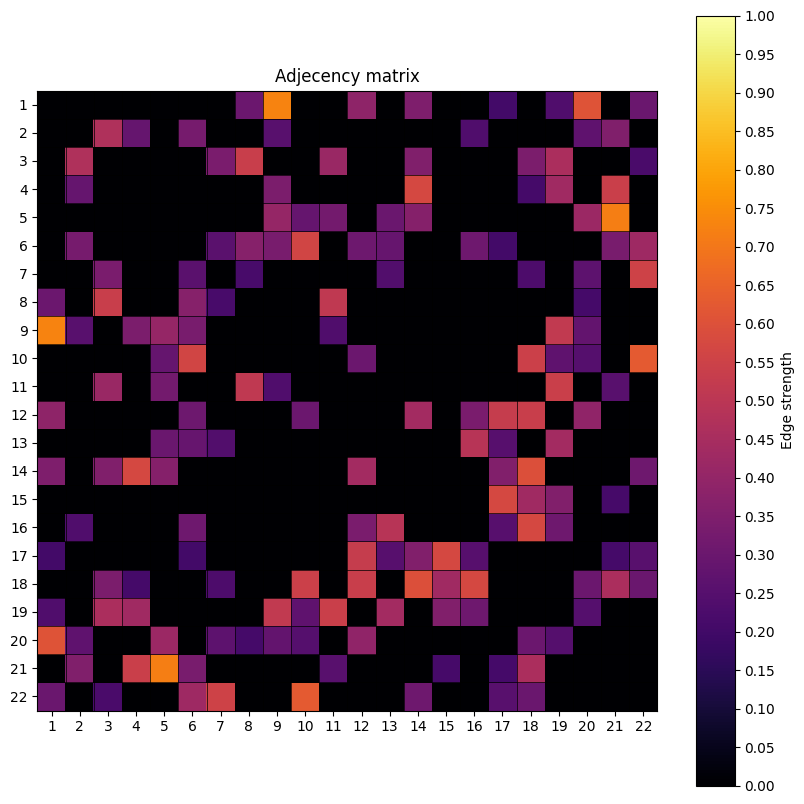

In [10]:
test_model = mods[0][0]
test_model2 = mods[1][0]

adj1 = get_adj_mat(test_model)
adj2 = get_adj_mat(test_model2)

visualize_adj_mat(adj1)

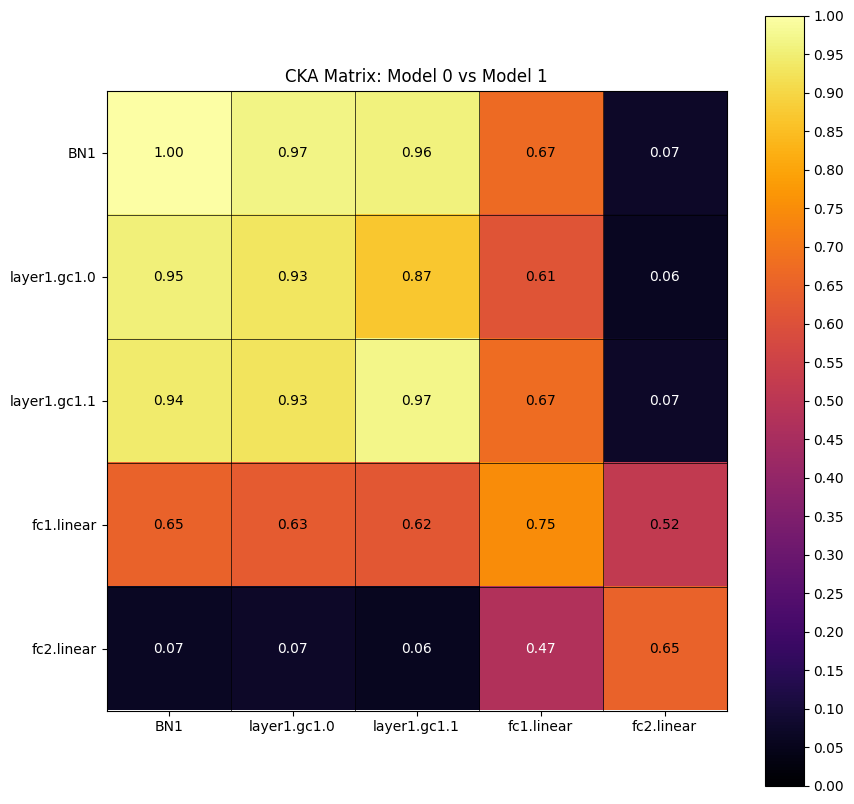

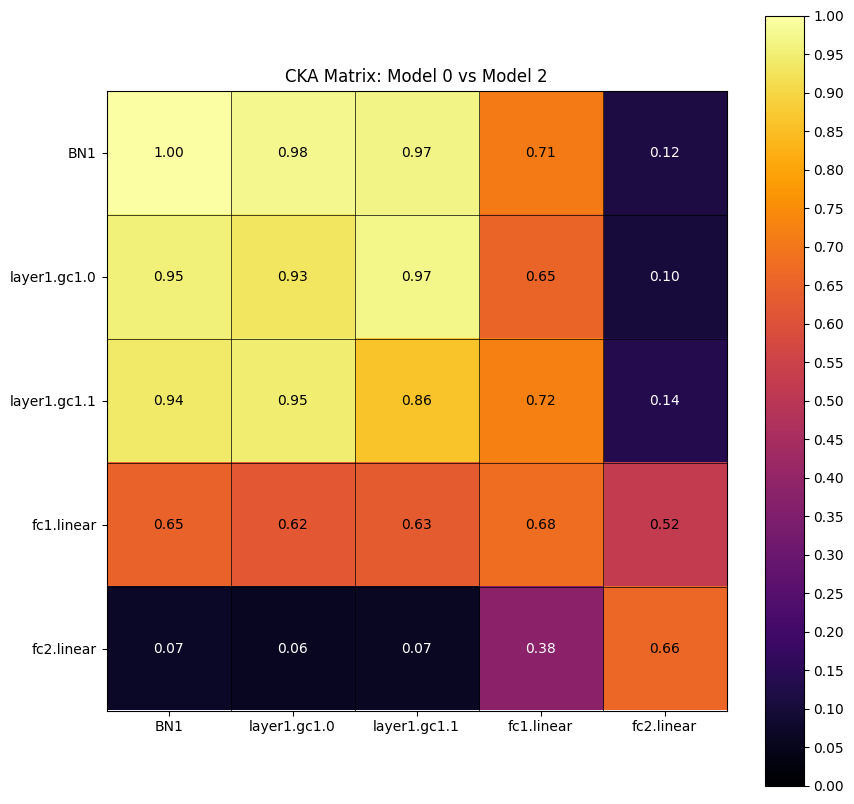

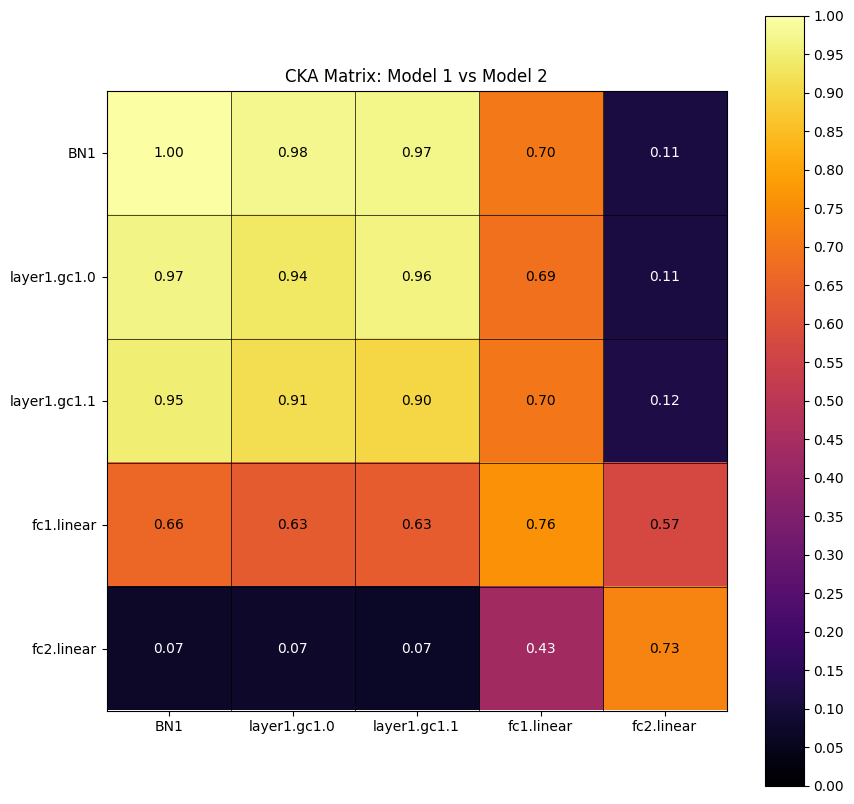

In [11]:
cka_all = []
for i in range(modruns-1):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        cka_all.append(cka_output)
        if plot:
            plot_matrix(f'CKA Matrix: Model {i} vs Model {j}',cka_output.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)


In [16]:
num_test=10
Matrix_field_val = np.zeros(num_test)
for i in range(num_test):
    calculator = CKACalculator(model1=mods[0][0], model2=mods[1][0], dataloader=train_loader,
                                    layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
    cka_output = calculator.calculate_cka_matrix(train_dataset)
    Matrix_field_val[i]=cka_output[0][4]

In [17]:
print(f"Standard deviation: {np.std(Matrix_field_val)}")
print(f"Array max: {max(Matrix_field_val)}\nArray min: {min(Matrix_field_val)}\nArray mean: {np.mean(Matrix_field_val)}")


Standard deviation: 0.0
Array max: 0.12315517663955688
Array min: 0.12315517663955688
Array mean: 0.12315517663955688


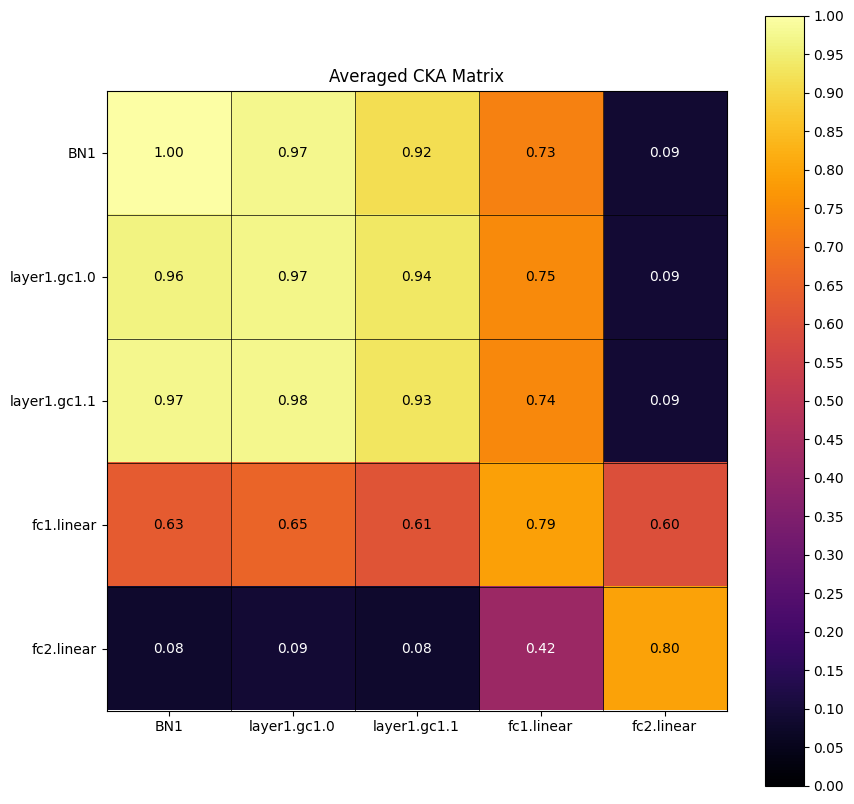

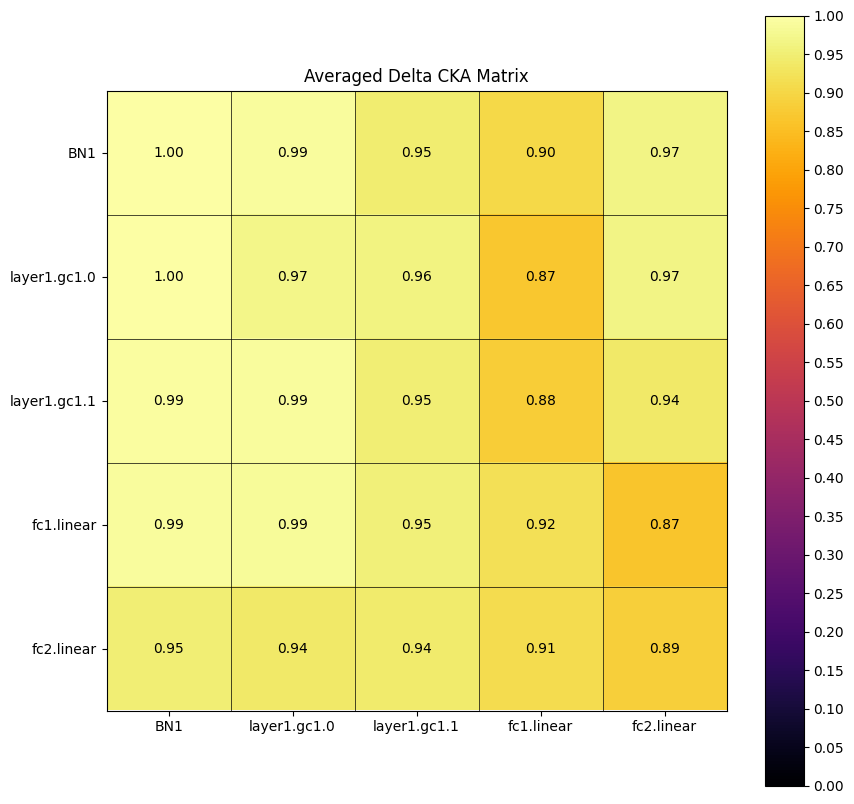

In [18]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  

plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

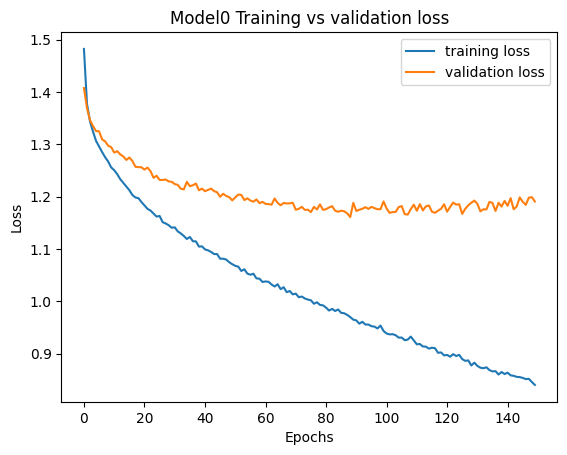

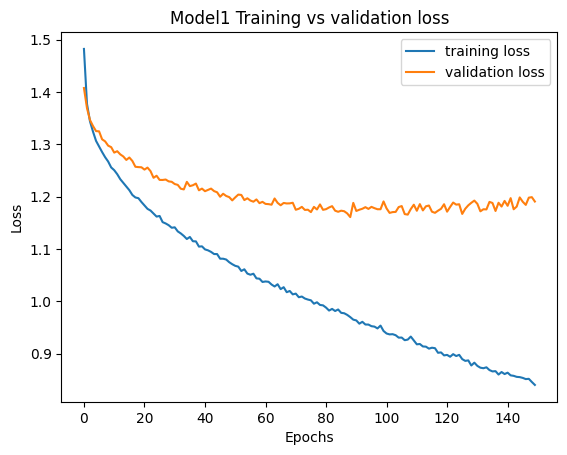

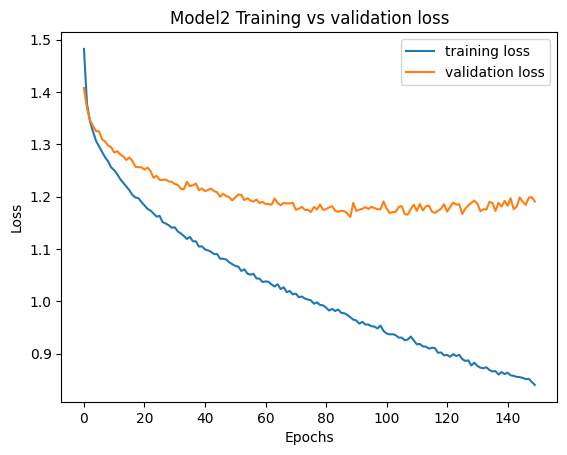

In [19]:
if has_val_set:

    for i  in range (len(mods)):
        filepath=f"{path}/Training_validation_loss{i}.npy"
        if not new_models:
            try: 
                with open(filepath, "rb") as f:
                    data = np.load(f)
            except:
                print(f"File with the data could not be found looking at address: {filepath}")
        else:
            with open(filepath, "wb") as f:
                np.save(f, mods[0][1])
                data = mods[0][1]
        plt.plot(data[0])
        plt.plot(data[1])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["training loss","validation loss"])
        plt.title(f"Model{i} Training vs validation loss")
        plt.show()
    